# Engineered Features Train

对经过特征工程处理后的数据进行训练，使用的模型是 `XGBoost`。


In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'Plus Engineered XGBoost'

In [2]:
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\New_Scripts\\Bg_pre2'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
from sklearn.base import clone
from xgboost import XGBRegressor

## Load Data

In [11]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'mp_plus_engineered_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mp_plus_engineered_test_set.csv'))

dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']

dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']


In [12]:
dft_train.shape, dft_test.shape

((7869, 220), (1963, 220))

In [13]:
# 从dft_train_X中抽取出一份验证集
mp_unique_comp = dft_train['composition'].unique()
len(mp_unique_comp)

7838

In [14]:
import random
# 从mp_unique_comp中随机采样组成
random.seed(RANDOM_SEED)
random_index = random.sample(range(len(mp_unique_comp)), round(dft_train.shape[0]*0.1))
mp_val_comp = mp_unique_comp[random_index]
hp_train_set = dft_train[~dft_train['composition'].isin(mp_val_comp)]
hp_val_set = dft_train[dft_train['composition'].isin(mp_val_comp)]
print(f'HP训练集大小：{len(hp_train_set)}')
print(f'HP验证集大小：{len(hp_val_set)}')

# Prepare data
hp_train_X = hp_train_set.drop(columns=['composition', 'band_gap'])
hp_train_y = hp_train_set['band_gap']
# 
hp_val_X = hp_val_set.drop(columns=['composition', 'band_gap'])
hp_val_y = hp_val_set['band_gap']

hp_train_X.shape, hp_train_y.shape, hp_val_X.shape, hp_val_y.shape

HP训练集大小：7082
HP验证集大小：787


((7082, 218), (7082,), (787, 218), (787,))

## Model Train

### HPO

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
param_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'learning_rate', 'n_estimators', 
                                      'max_depth', 'subsample', 'colsample_bytree', 'R²', 'RMSE', 'MAE'])
# Define the hyperparameter search space
import itertools

params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
}
n_iter = 100
scaler = StandardScaler()
scaled_dft_train_X = scaler.fit_transform(hp_train_X)
scaled_dft_val_X = scaler.transform(hp_val_X)

# 生成所有可能的参数组合
all_params = list(itertools.product(
    params['learning_rate'],
    params['n_estimators'],
    params['max_depth'],
    params['subsample'],
    params['colsample_bytree']
))

# 随机选择 n_iter 个组合
if n_iter > len(all_params):
    sampled_params_list = all_params
    print(f"Warning: n_iter is larger than the number of all possible combinations. Using all {len(all_params)} combinations.")
else:
    sampled_params_list = random.sample(all_params, n_iter)

for i, sampled_params_tuple in enumerate(sampled_params_list):
    sampled_params = {
        'learning_rate': sampled_params_tuple[0],
        'n_estimators': sampled_params_tuple[1],
        'max_depth': sampled_params_tuple[2],
        'subsample': sampled_params_tuple[3],
        'colsample_bytree': sampled_params_tuple[4]
    }

    print(f"[Iter {i+1}/{len(sampled_params_list)}] Sampled parameters: {sampled_params}")

    # Create the model with the sampled parameters
    model = XGBRegressor(
        learning_rate=sampled_params['learning_rate'],
        n_estimators=sampled_params['n_estimators'],
        max_depth=sampled_params['max_depth'],
        subsample=sampled_params['subsample'],
        colsample_bytree=sampled_params['colsample_bytree'],
        random_state=RANDOM_SEED, n_jobs=-1, verbosity=0
    ) 
    # fit the model
    model.fit(scaled_dft_train_X, hp_train_y)
    # Predict
    train_pred = model.predict(scaled_dft_train_X)
    val_pred = model.predict(scaled_dft_val_X)
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(hp_train_y, train_pred))
    val_rmse = np.sqrt(mean_squared_error(hp_val_y, val_pred))
    train_r2 = r2_score(hp_train_y, train_pred)
    val_r2 = r2_score(hp_val_y, val_pred)
    train_mae = mean_absolute_error(hp_train_y, train_pred)
    val_mae = mean_absolute_error(hp_val_y, val_pred)

    # Append metrics to DataFrame
    param_metrics.loc[len(param_metrics)] = {
        'Model': MODEL_NAME,
        'Error_Type': 'Train',
        'learning_rate': sampled_params['learning_rate'],
        'n_estimators': sampled_params['n_estimators'],
        'max_depth': sampled_params['max_depth'],
        'subsample': sampled_params['subsample'],
        'colsample_bytree': sampled_params['colsample_bytree'],
        'R²': train_r2,
        'RMSE': train_rmse,
        'MAE': train_mae
    }
    # Append validation metrics to DataFrame
    param_metrics.loc[len(param_metrics)] = {
        'Model': MODEL_NAME,
        'Error_Type': 'Validation',
        'learning_rate': sampled_params['learning_rate'],
        'n_estimators': sampled_params['n_estimators'],
        'max_depth': sampled_params['max_depth'],
        'subsample': sampled_params['subsample'],
        'colsample_bytree': sampled_params['colsample_bytree'],
        'R²': val_r2,
        'RMSE': val_rmse,
        'MAE': val_mae
    }
    # 计算训练集和验证集的RMSE
    print(f"Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")


# 输出最优参数
best_val_index = param_metrics[param_metrics['Error_Type'] == 'Validation']['RMSE'].idxmin()
best_val_params = param_metrics.iloc[best_val_index]
print(f"Best Validation Parameters: {best_val_params['learning_rate']}, {best_val_params['n_estimators']}, {best_val_params['max_depth']}, {best_val_params['subsample']}, {best_val_params['colsample_bytree']}")
print(f"Best Validation RMSE: {best_val_params['RMSE']}")

# save the results to a csv file
hp_path = os.path.join(current_path, 'hp_search')
os.makedirs(hp_path, exist_ok=True)
param_metrics.sort_values(by=['Error_Type', 'RMSE'], ascending=[False, True], inplace=True).reset_index(drop=True, inplace=True)
param_metrics.to_csv(os.path.join(hp_path, f'{MODEL_NAME}_metrics.csv'), index=False)

In [37]:
best_val_params

Model               Plus Engineered XGBoost
Error_Type                       Validation
learning_rate                          0.05
n_estimators                            300
max_depth                                11
subsample                               0.7
closample_bytree                        NaN
R²                                 0.692295
RMSE                               0.469753
MAE                                0.345112
Name: 119, dtype: object

### Test

In [15]:
fig_path = os.path.join(current_path, 'figures', 'MP_plus_engineered')
os.makedirs(fig_path, exist_ok=True)

####################################################################################################
[DFT - Plus Engineered XGBoost] Training Plus Engineered XGBoost on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=   8.4s
Model training completed!
[Train_error] Evaluating DFT Plus Engineered XGBoost on DFT train set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\MP_plus_engineered\train_error.png


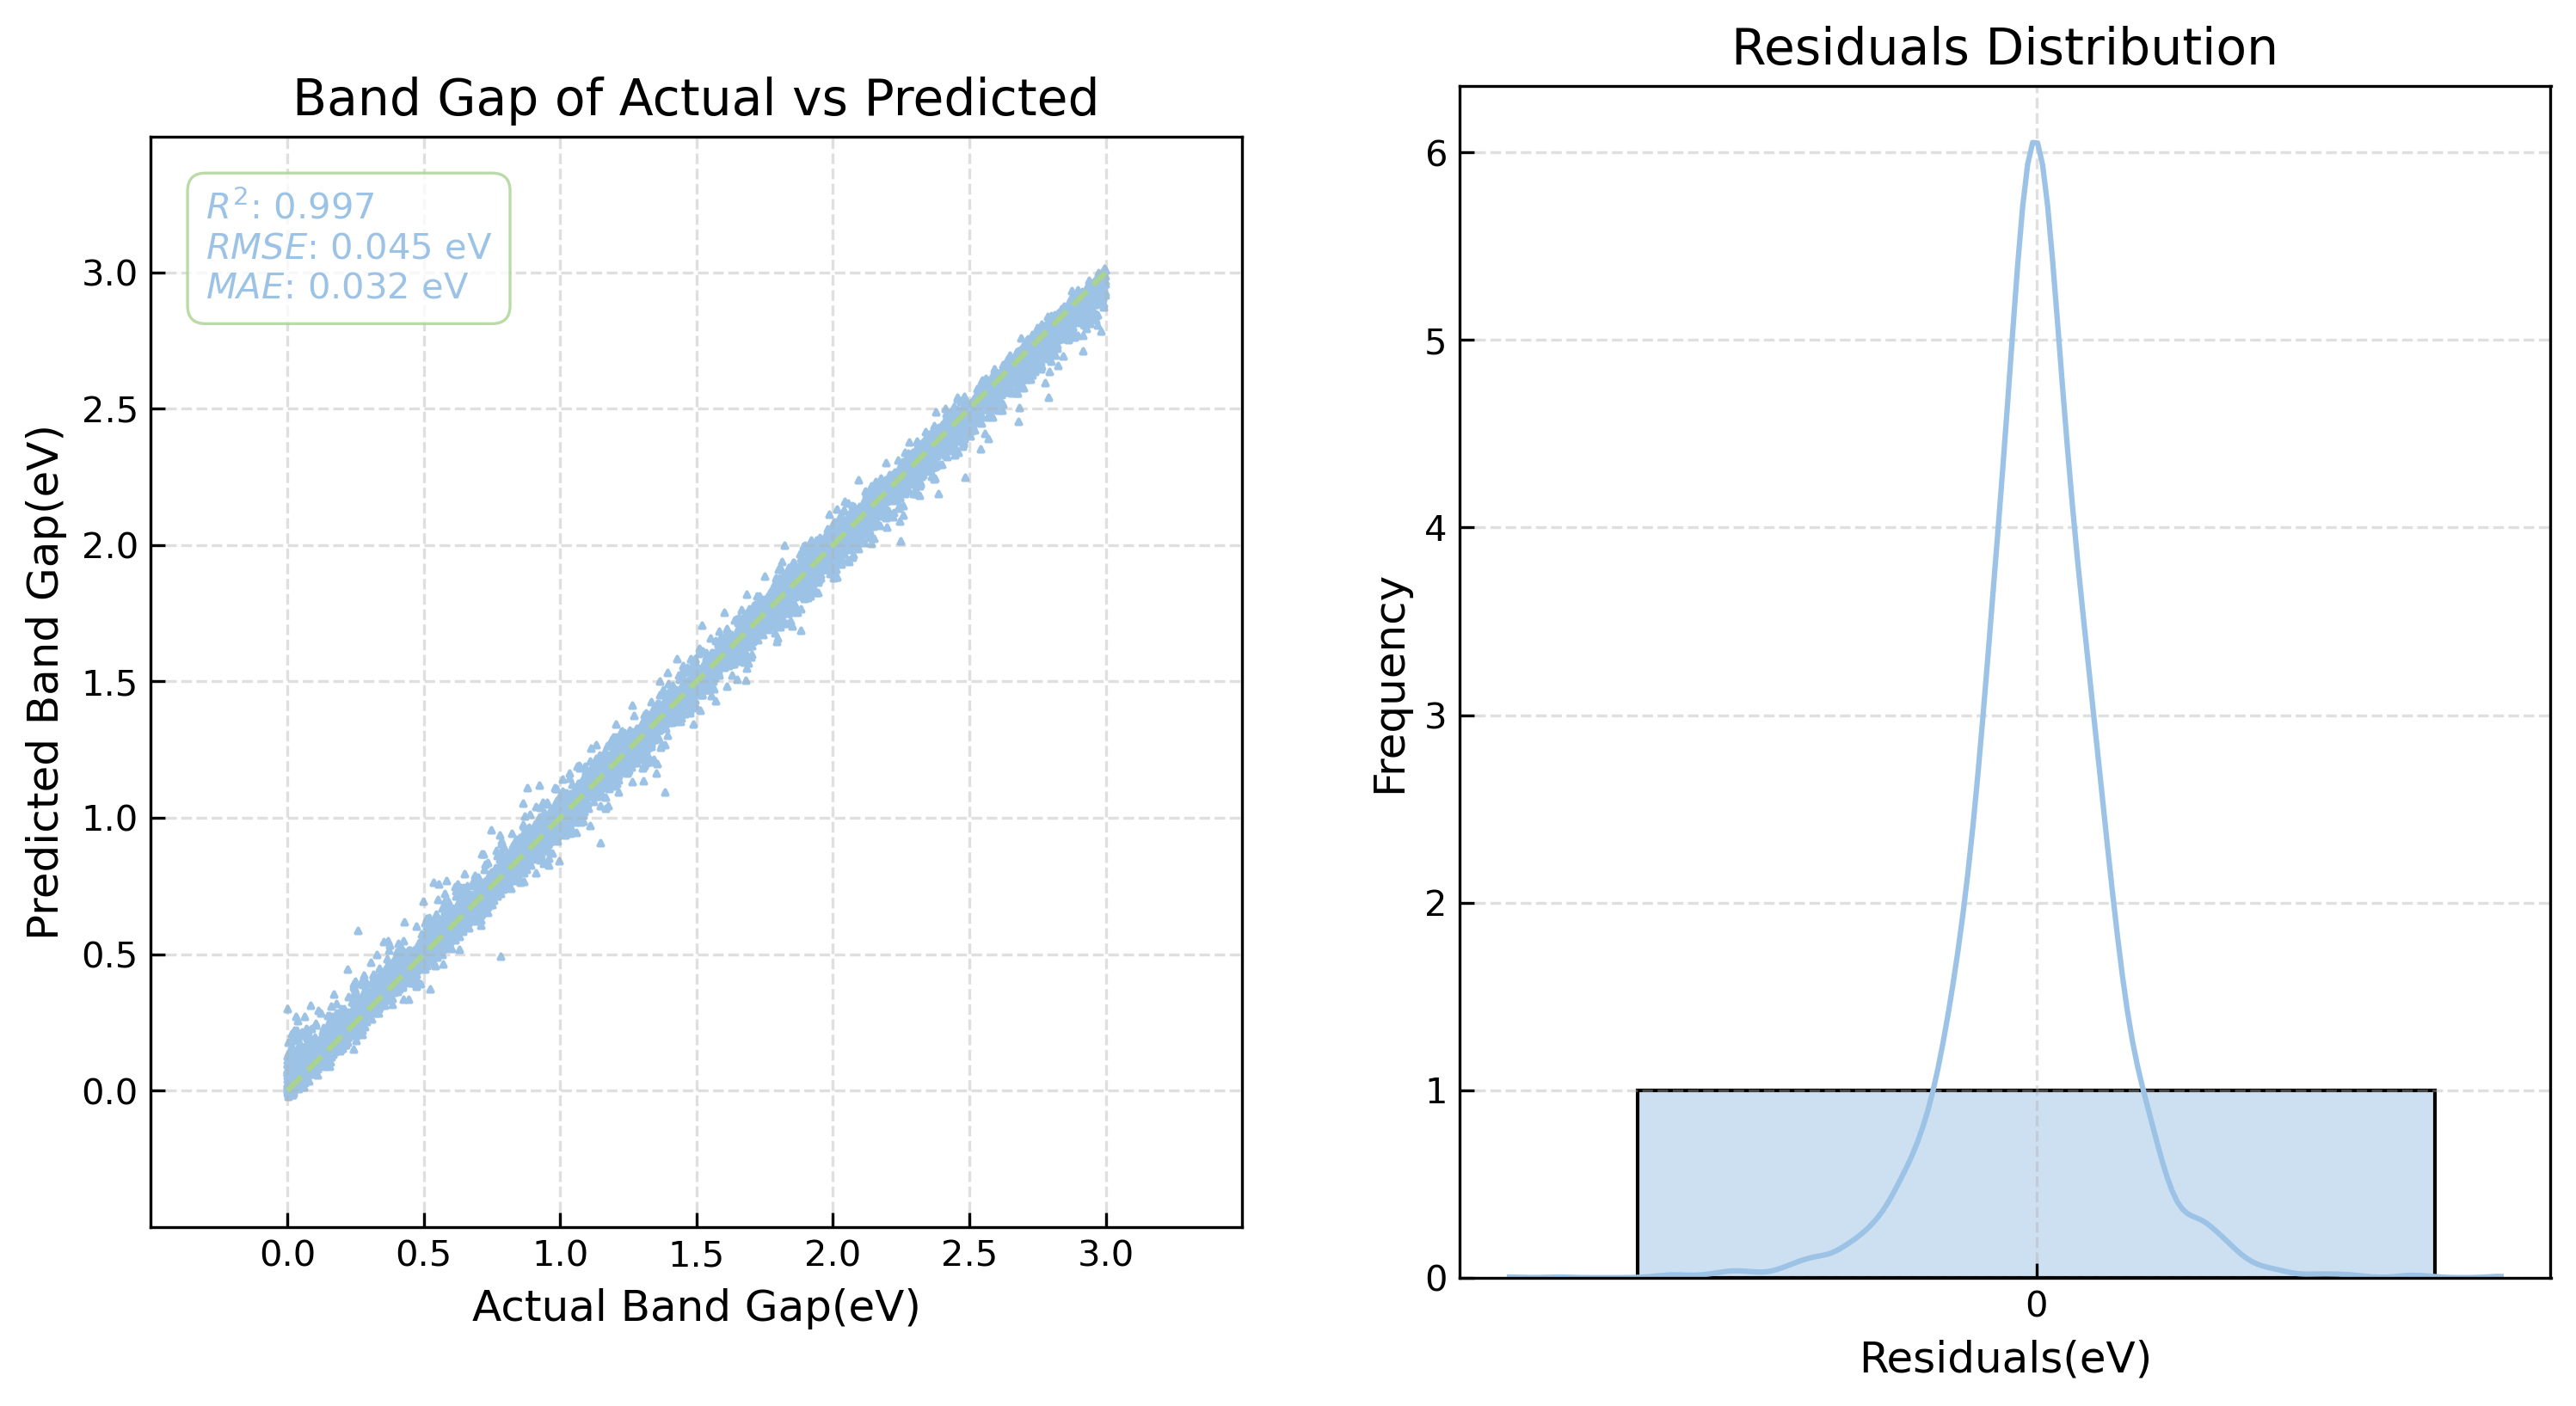


Model Evaluation Results:
Test set size: 7869
Test set: R²: 0.9972 RMSE: 0.0448 MAE: 0.0320 MAPE: 131.4422%
[Test DFT -> DFT] Evaluating DFT Plus Engineered XGBoost on DFT test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\MP_plus_engineered\test_error.png


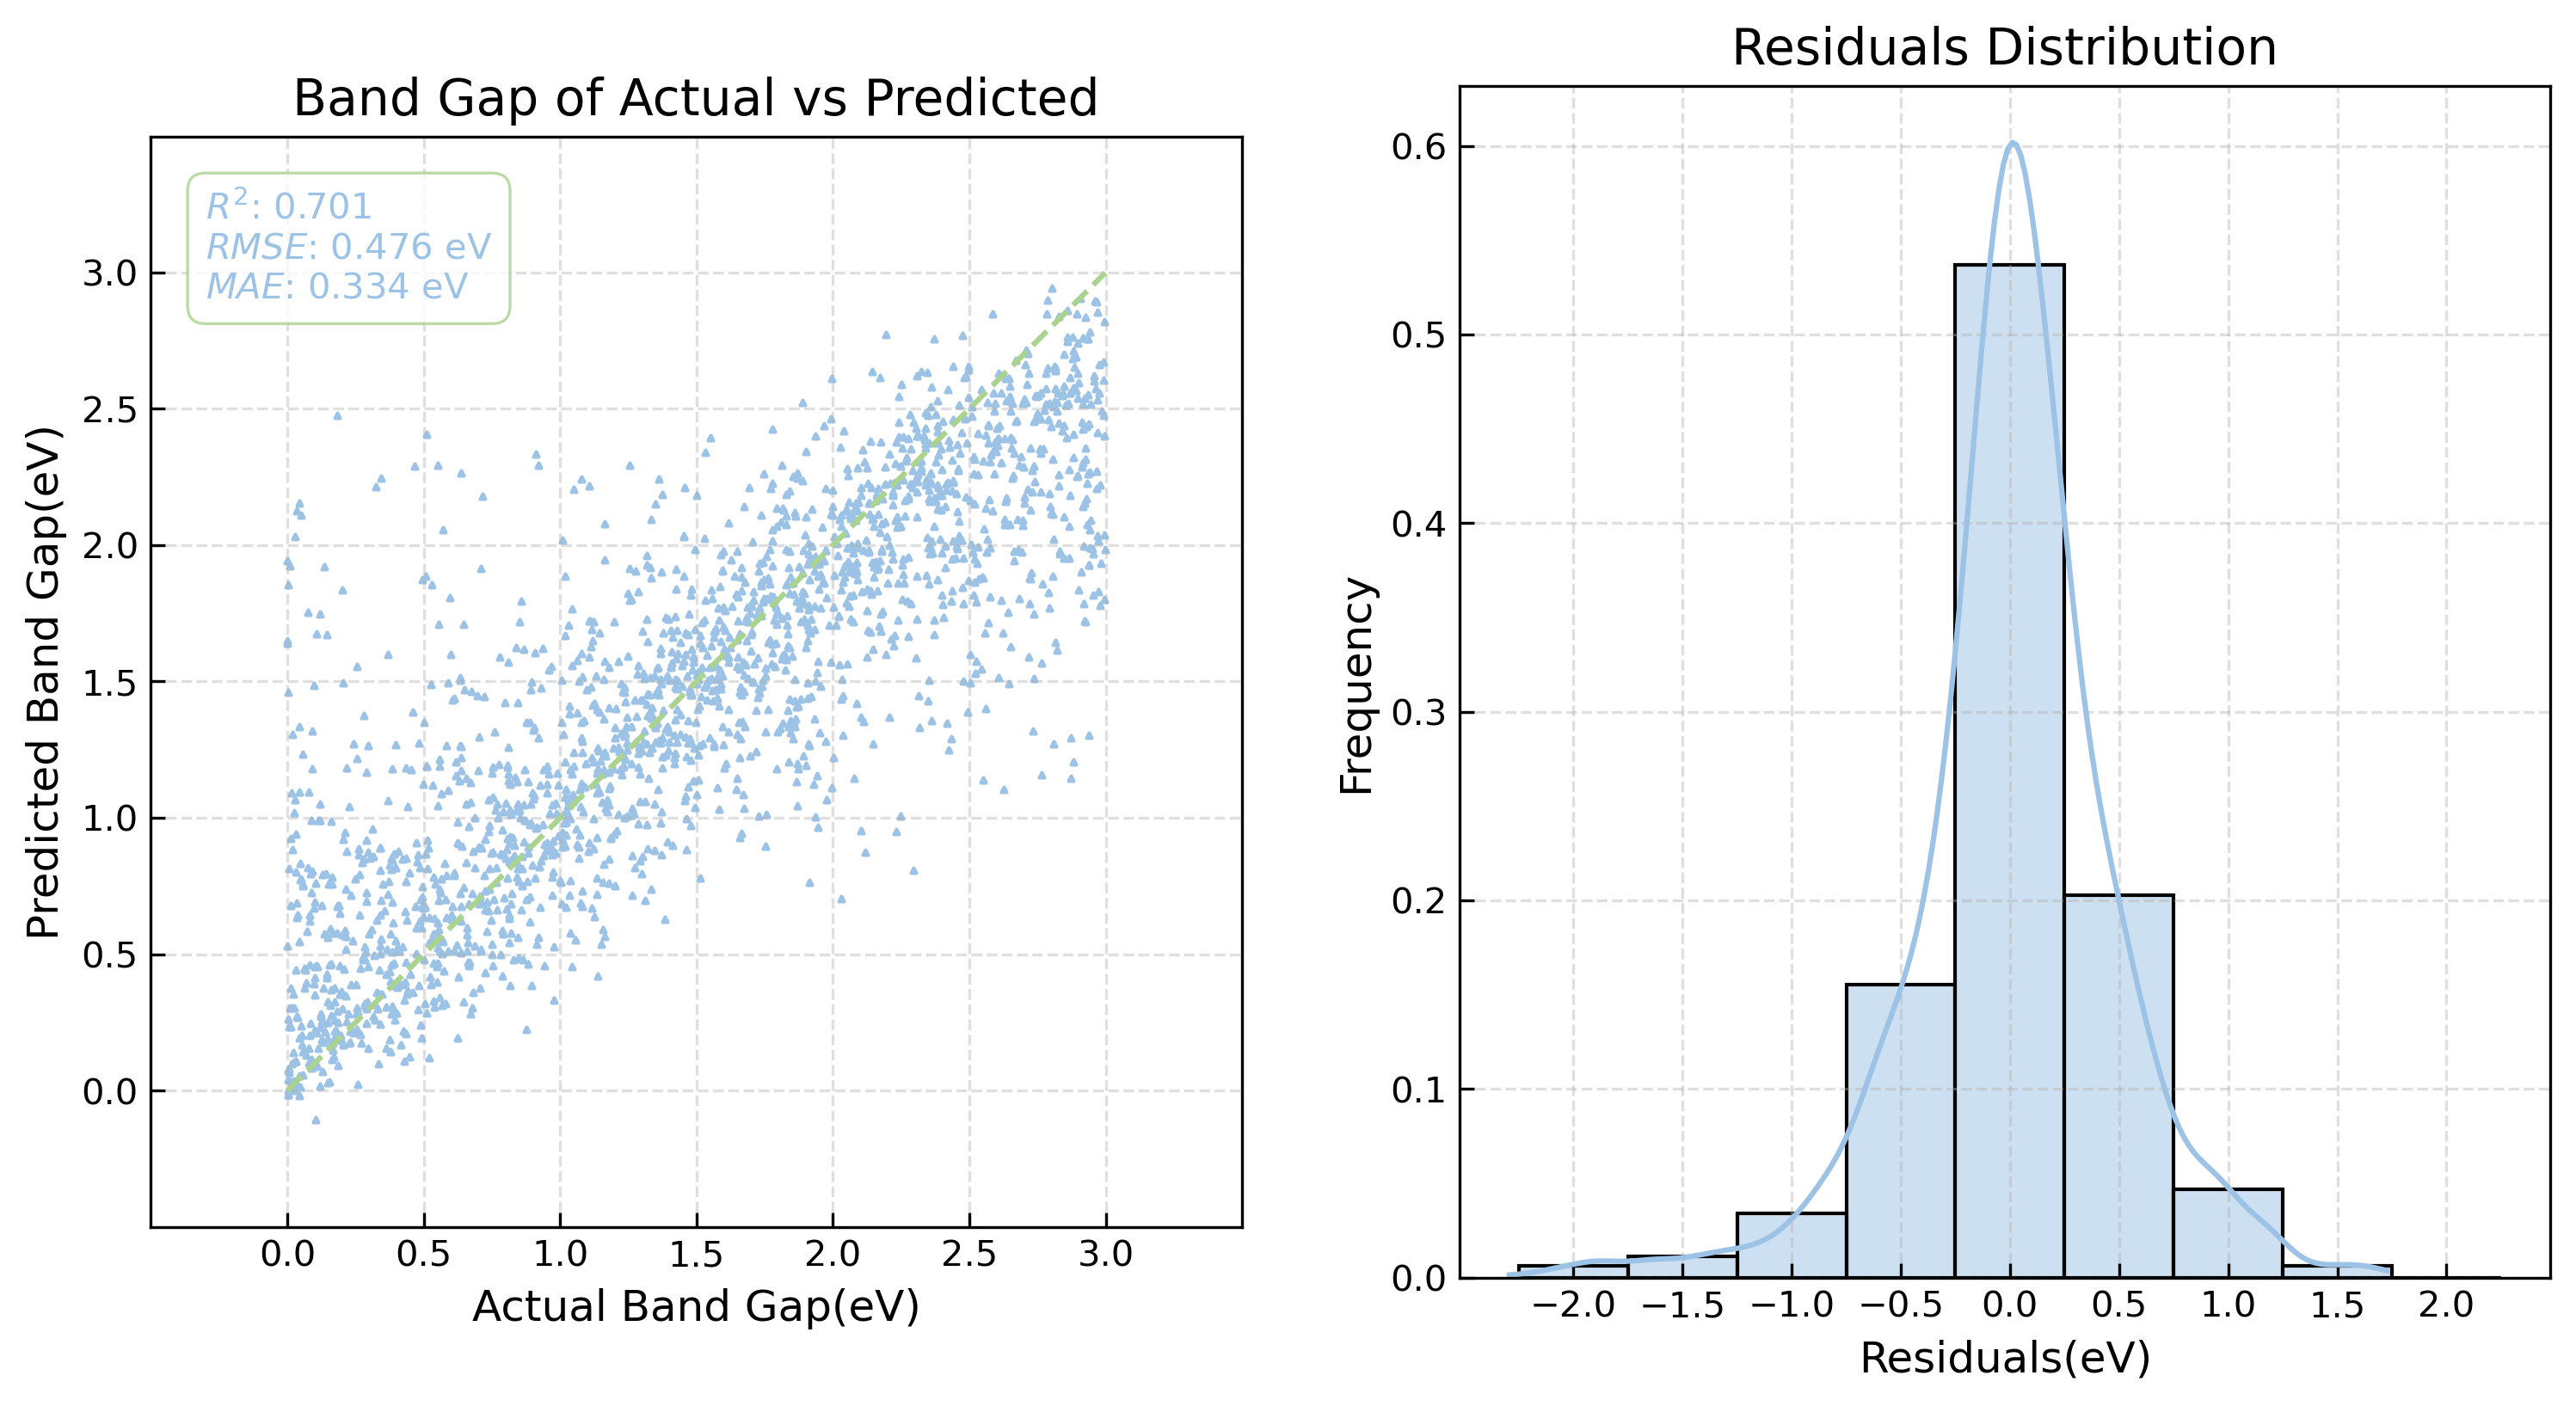


Model Evaluation Results:
Test set size: 1963
Test set: R²: 0.7009 RMSE: 0.4755 MAE: 0.3344 MAPE: 1480.2188%


In [16]:
xgboost_best = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
# record model metrics
model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
# Train the model on dft data
print("#" * 100)
print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
print("-" * 100)

dft_model = SingleModel(clone(xgboost_best), random_state=RANDOM_SEED)
dft_model.train(dft_train_X, dft_train_y)

# evaluate on the dft train set
print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
metrics = dft_model.evaluate(dft_train_X, dft_train_y, fig_path=os.path.join(fig_path, 'train_error.png'))
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Train',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

# evaluate on the dft test set
print(f"[Test DFT -> DFT] Evaluating DFT {MODEL_NAME} on DFT test set:")

metrics = dft_model.evaluate(dft_test_X, dft_test_y, fig_path=os.path.join(fig_path, 'test_error.png'))
model_metrics.loc[len(model_metrics)] = {
'Model': MODEL_NAME,
'Error_Type': 'Test',
'Train_set': 'dft',
'Test_set': 'dft',
'R²': metrics['r2'],
'RMSE': metrics['rmse'],
'MAE': metrics['mae']
}

Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\MP_plus_engineered\feature_importance.png


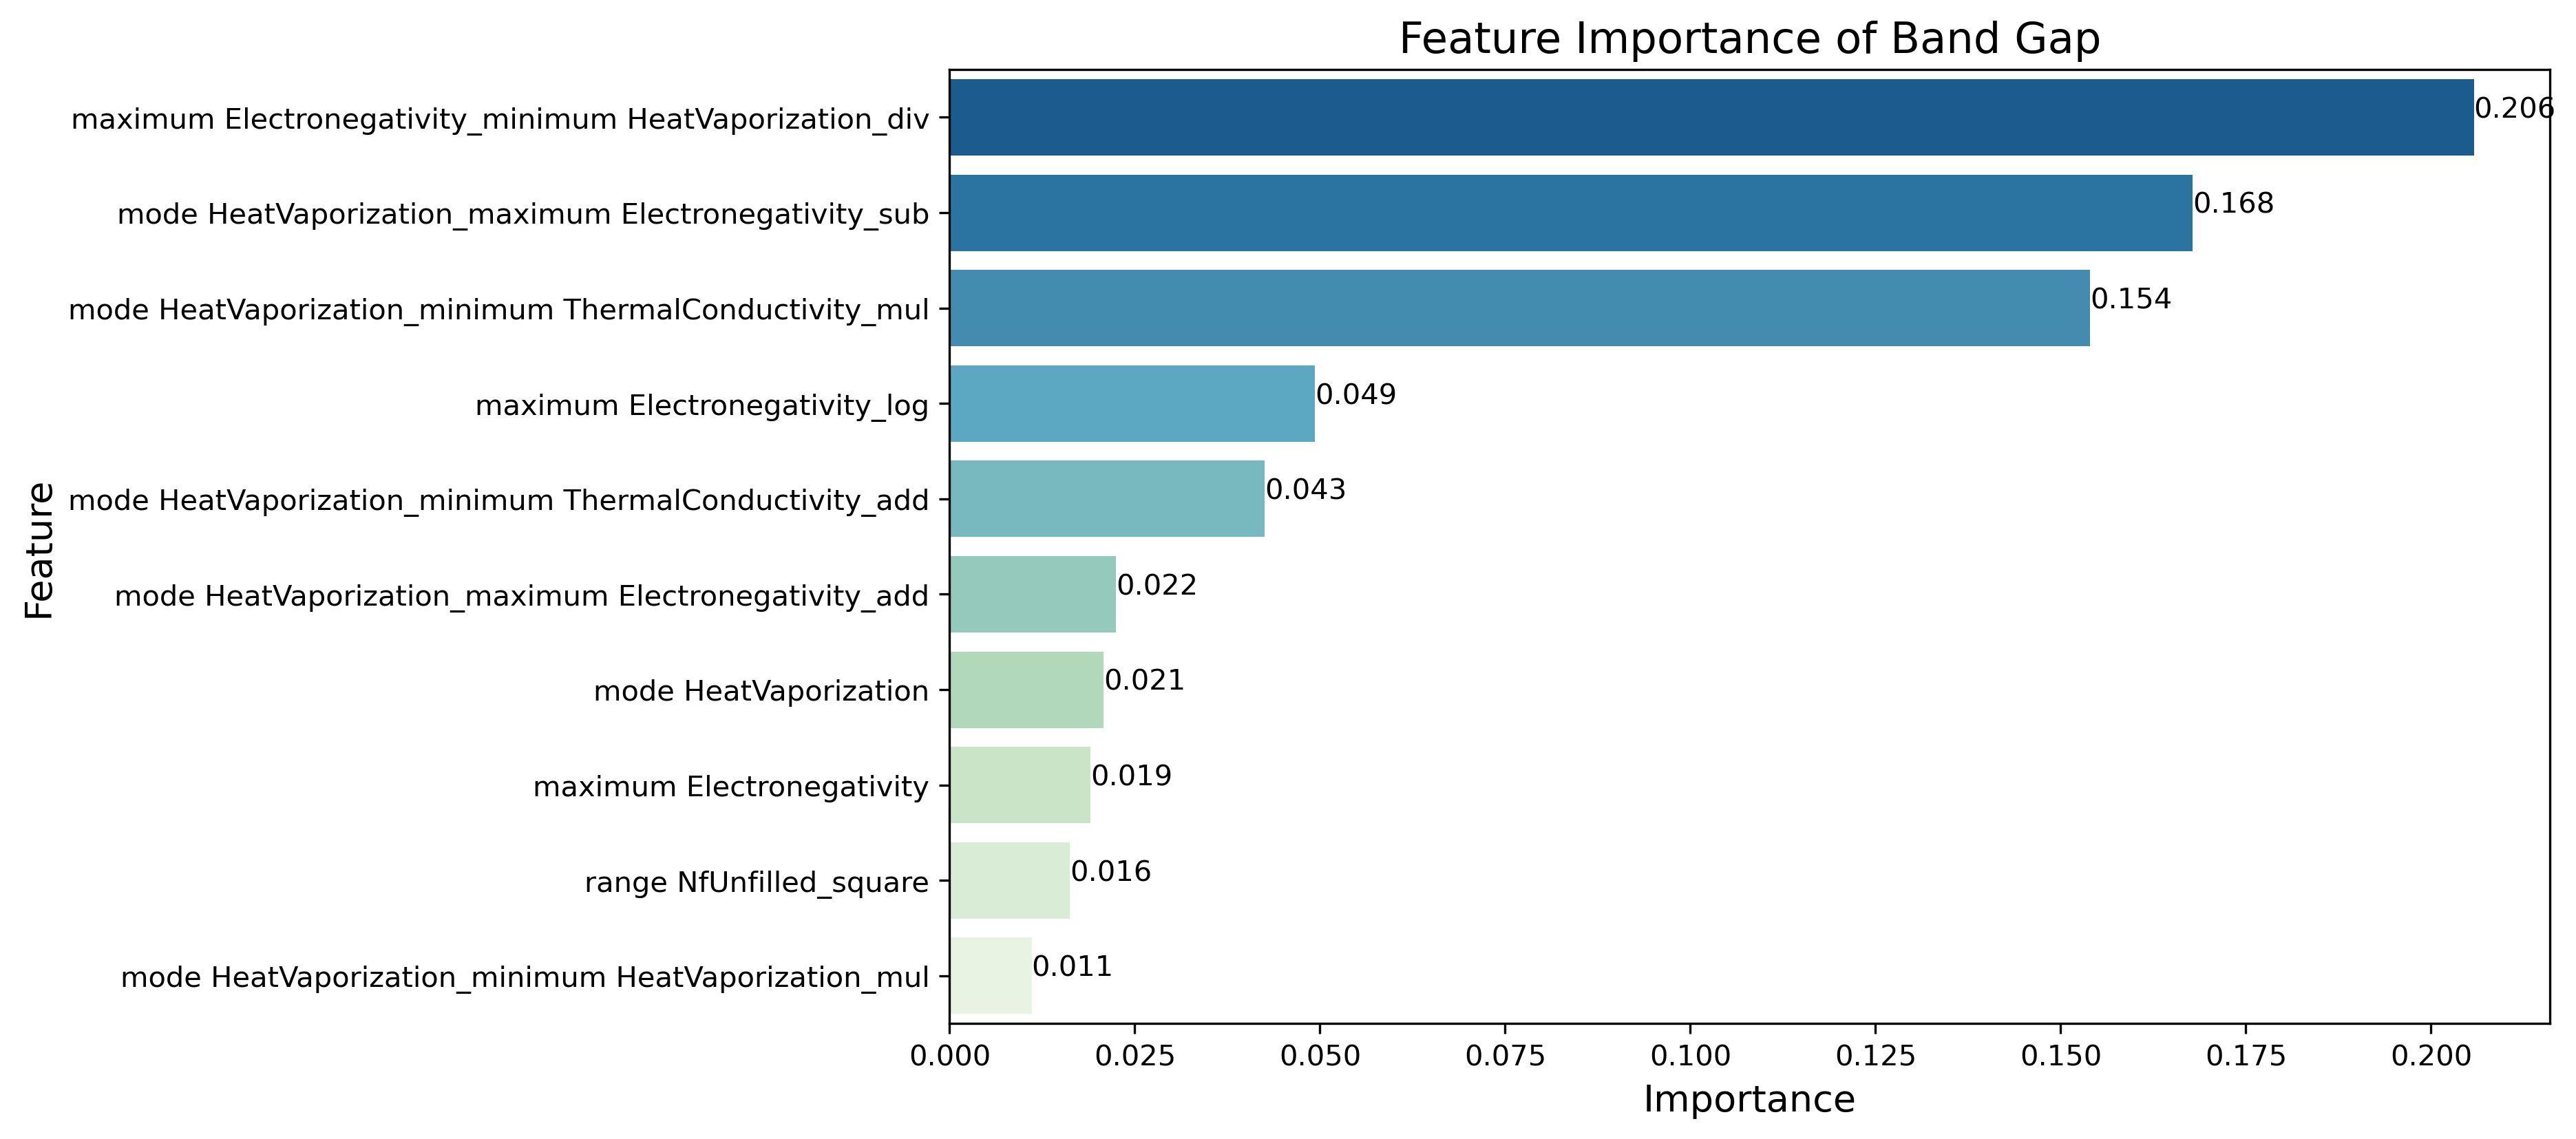

In [17]:
# 绘制特征重要性图
from Utools.draw import plot_feature_importance
importances_df = plot_feature_importance(dft_model.get_model(), dft_train_X.columns, top_n=10,
                            fig_path=os.path.join(fig_path, f'feature_importance.png'))  
# save the feature importance dataframe to a csv file
path = os.path.join(current_path, 'metrics', 'feature_importance', 'mp_plus_engineered')
os.makedirs(path, exist_ok=True)
importances_df.to_csv(os.path.join(path, 'feature_importance.csv'), index=False)

In [18]:
model_metrics.head()

,Model,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,Plus Engineered XGBoost,Train,dft,dft,0.997247,0.044816,0.032017
1,Plus Engineered XGBoost,Test,dft,dft,0.700912,0.475531,0.334413


In [19]:
# Save the model metrics to a CSV file
model_metrics.to_csv(os.path.join('./metrics', 'mp_plus_engineered_metrics.csv'), index=False)

## 误差分析

In [ ]:
y_pred = dft_model.predict(dft_test_X)
y_pred

array([0.79526836, 0.868662  , 0.89417726, ..., 2.1019878 , 0.7928232 ,
       1.9253554 ], shape=(2074,), dtype=float32)

In [ ]:
dft_test['y_pred'] = y_pred
dft_test.head()

,composition,nsites,crystal_system,space_group,volume,density,density_atomic,efermi,energy_per_atom,formation_energy_per_atom,...,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,y_pred
0,Ac1H3,4,0,225,49.065716,7.784734,12.266429,6.594725,-20.422506,-0.671802,...,0.0,0.0,0.0,194.0,225.0,31.0,201.750000,11.625000,194.0,0.795268
1,Ac2N2,4,2,186,99.880235,8.013618,24.970059,5.276132,-40.205678,-1.322563,...,0.0,0.0,0.0,194.0,225.0,31.0,209.500000,15.500000,194.0,0.868662
2,Ag4Ge2Pb2S8,16,3,40,364.725495,5.680462,22.795343,3.729416,-4.371751,-0.549878,...,0.0,0.0,0.0,70.0,225.0,155.0,147.500000,77.500000,70.0,0.894177
3,Ag4Hg2S2I4,12,3,36,397.001425,5.874191,33.083452,1.311221,-2.638433,-0.441444,...,0.0,0.0,0.0,64.0,225.0,161.0,135.666667,69.666667,64.0,1.212781
4,Ag4P4Pd2O14,24,4,15,346.044808,4.761193,14.418534,1.535796,-6.480136,-1.785767,...,0.0,0.0,0.0,2.0,225.0,223.0,63.583333,80.708333,12.0,0.974411


In [ ]:
dft_test['error'] = np.abs(dft_test['y_pred'] - dft_test['band_gap'])
dft_test['error'].describe()

count    2074.000000
mean        0.325694
std         0.316851
min         0.000213
25%         0.096639
50%         0.225544
75%         0.454785
max         2.074969
Name: error, dtype: float64

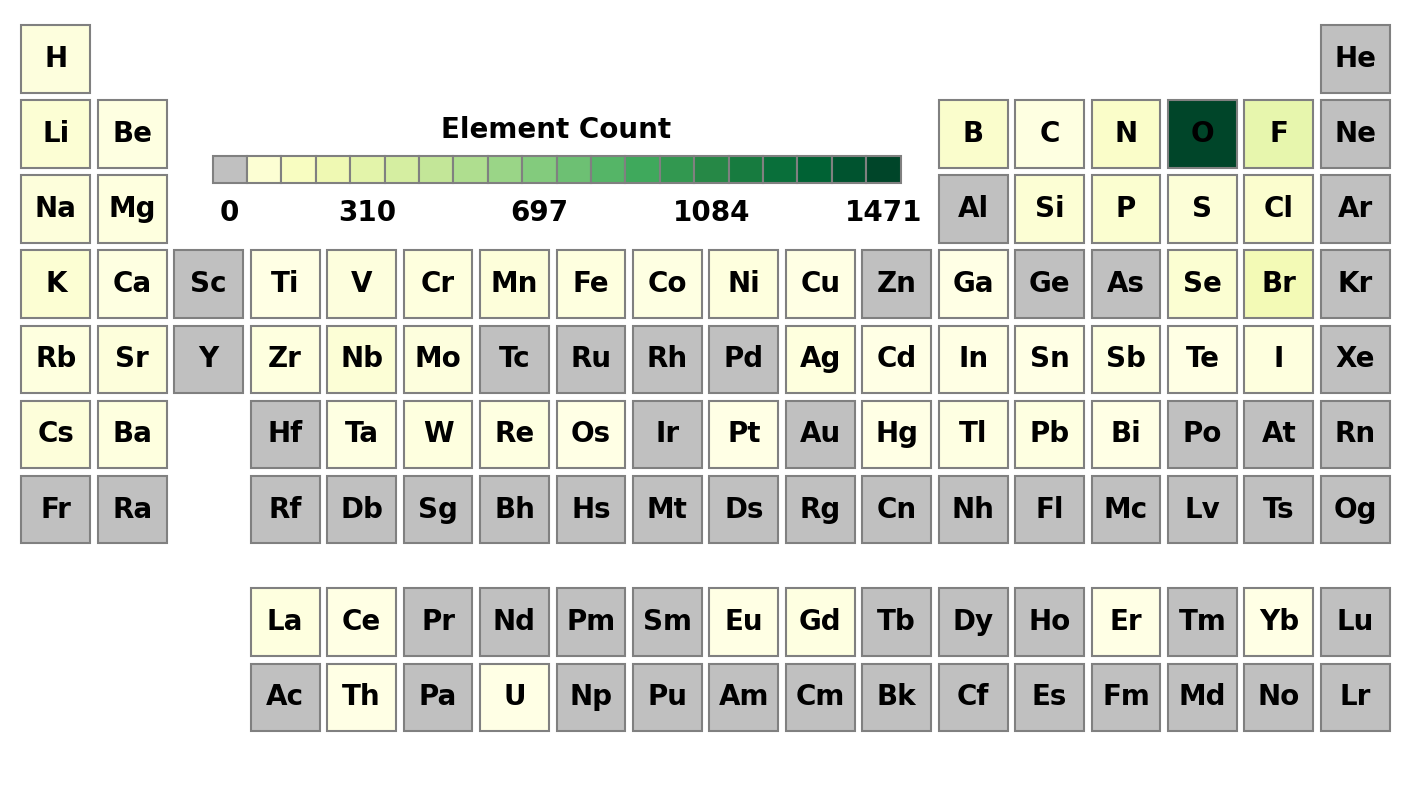

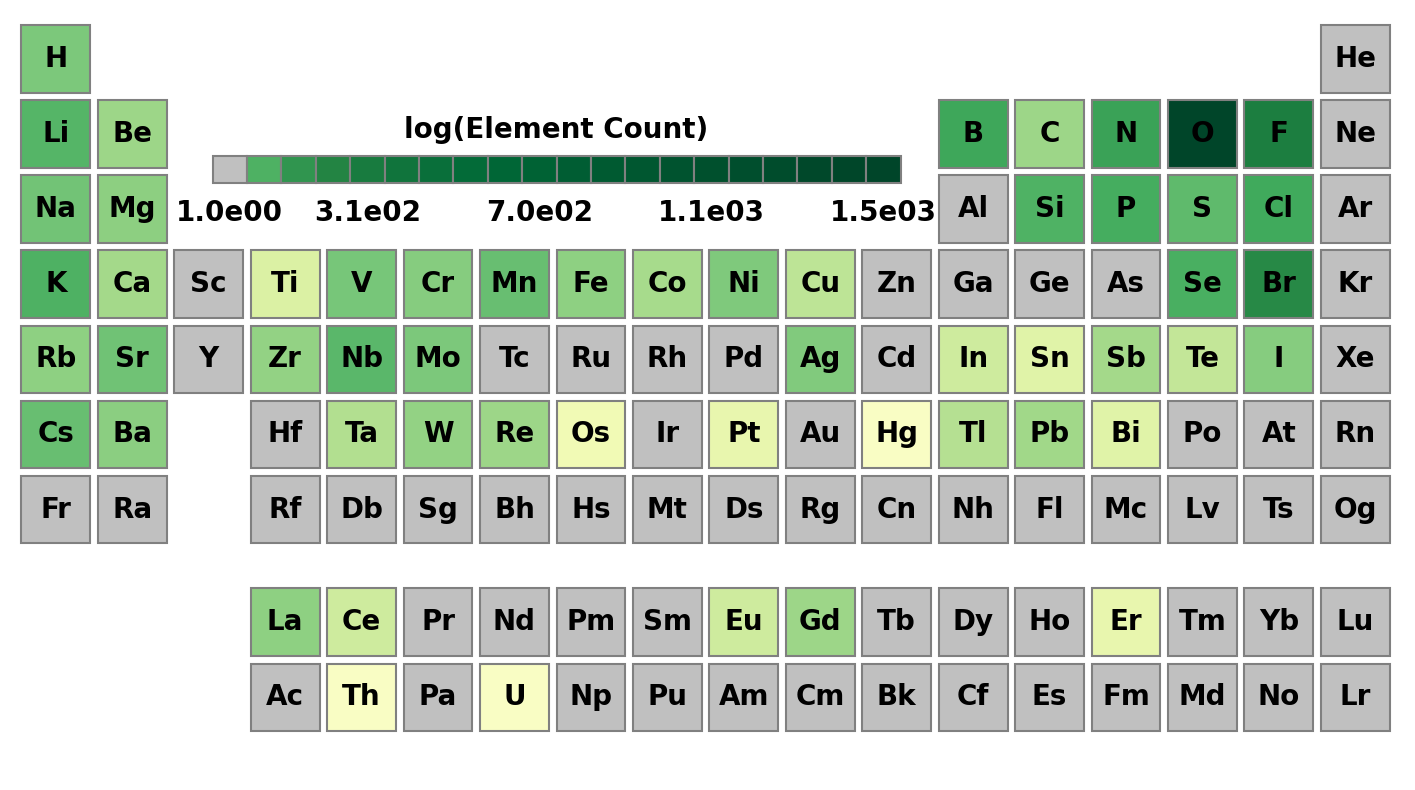

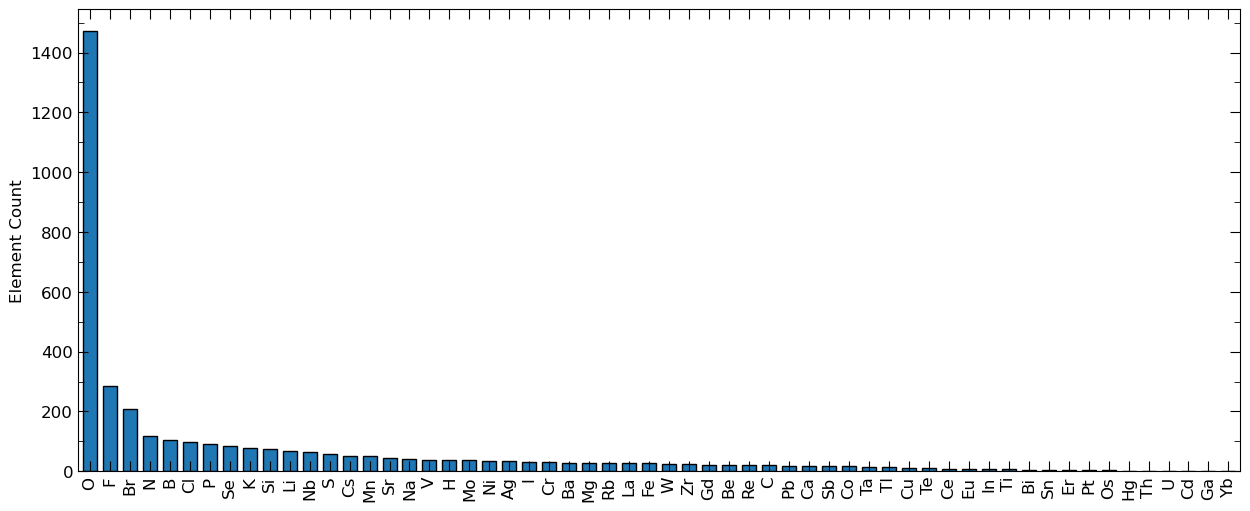

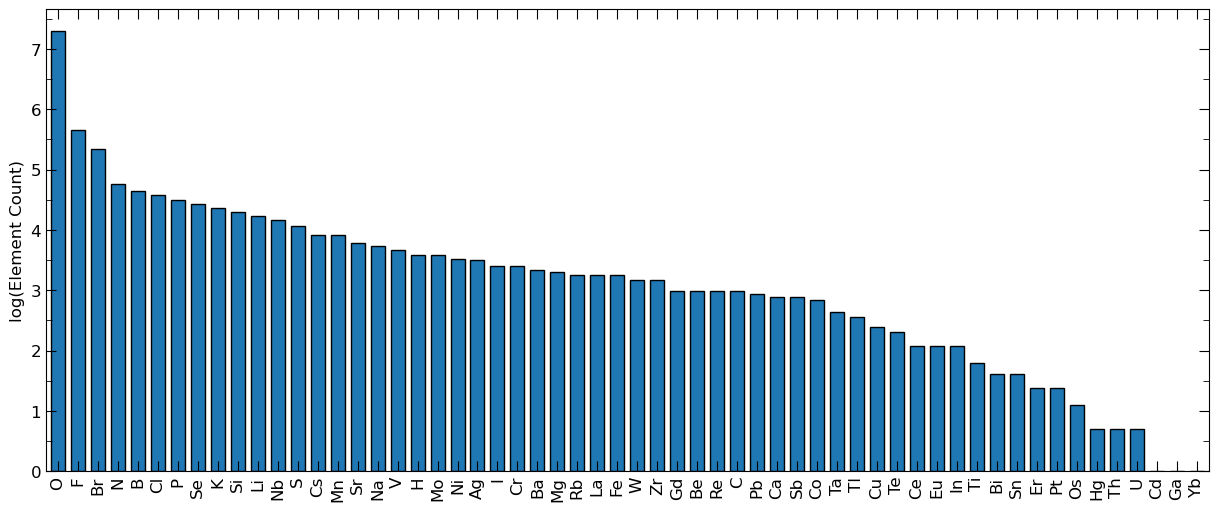

In [ ]:
# 误差大于1eV的元素分布
from Utools.ML_figures.figures import element_prevalence
import matplotlib.pyplot as plt

data_df = dft_test[dft_test['error'] > 1.0].copy()
current_dir = os.getcwd()
os.chdir('./Utools')  # Change to where ML_figures is a direct subdirectory

formula = data_df['composition']
save_dir = os.path.join(fig_path, 'error_greater_than_1eV_elements_distribution')
os.makedirs(save_dir, exist_ok=True)
element_prevalence(formula,
                   name='element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=True)

plt.rcParams.update({'font.size': 12})
element_prevalence(formula,
                   name='element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=True)

os.chdir(current_dir)  # Return to previous directory

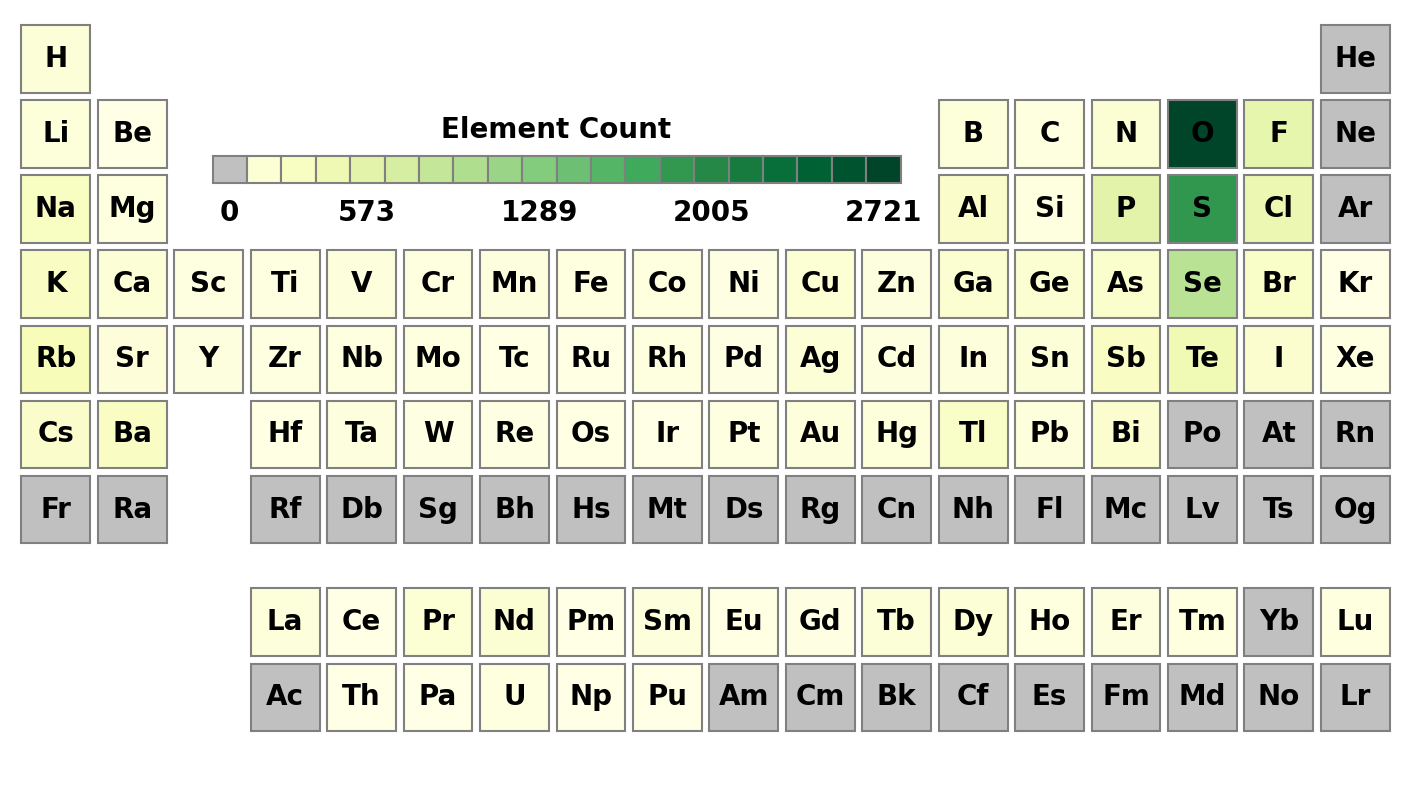

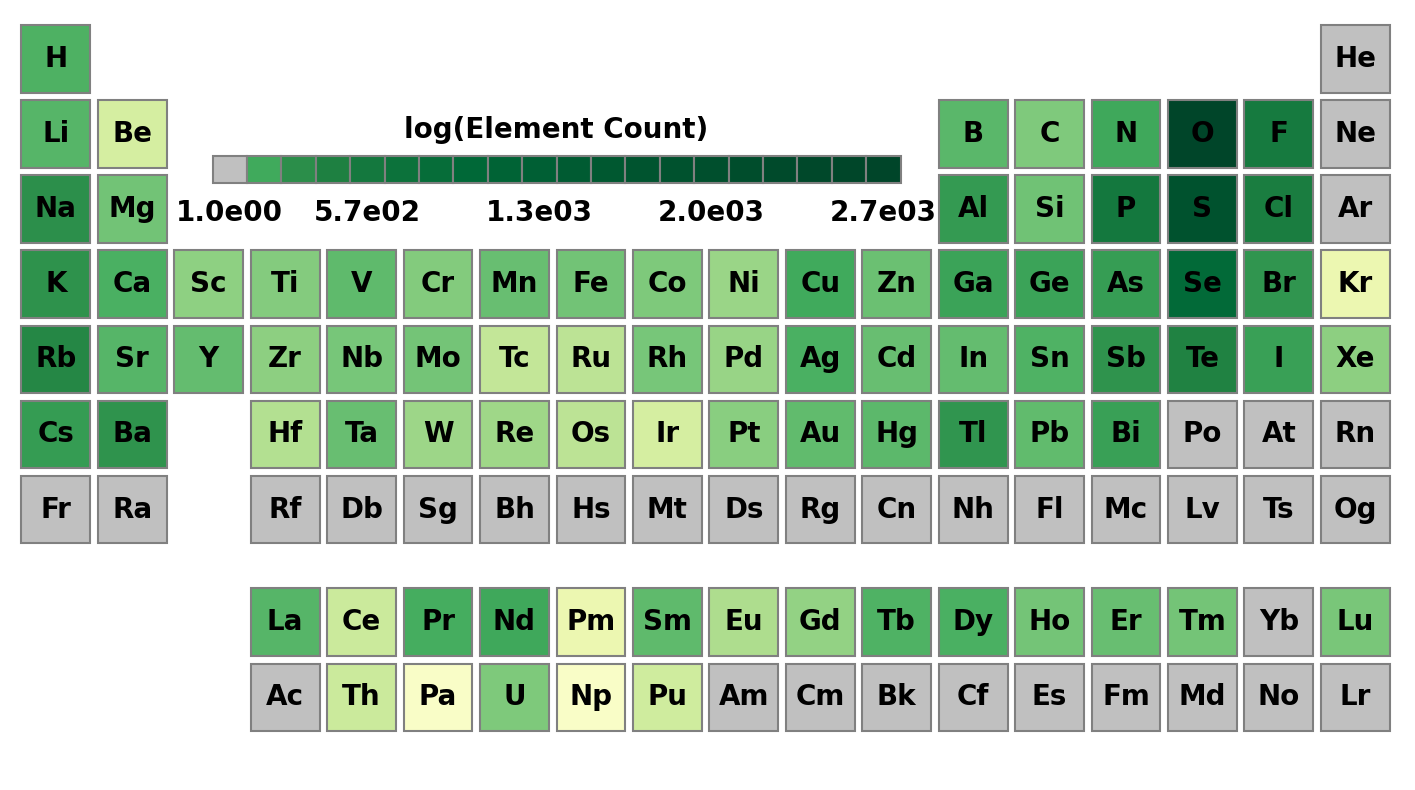

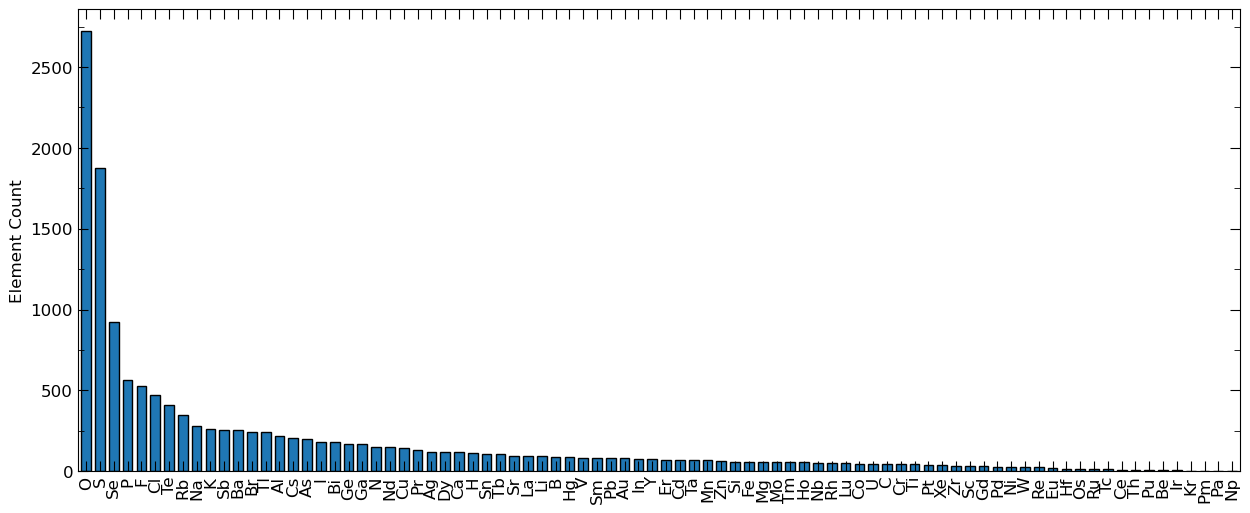

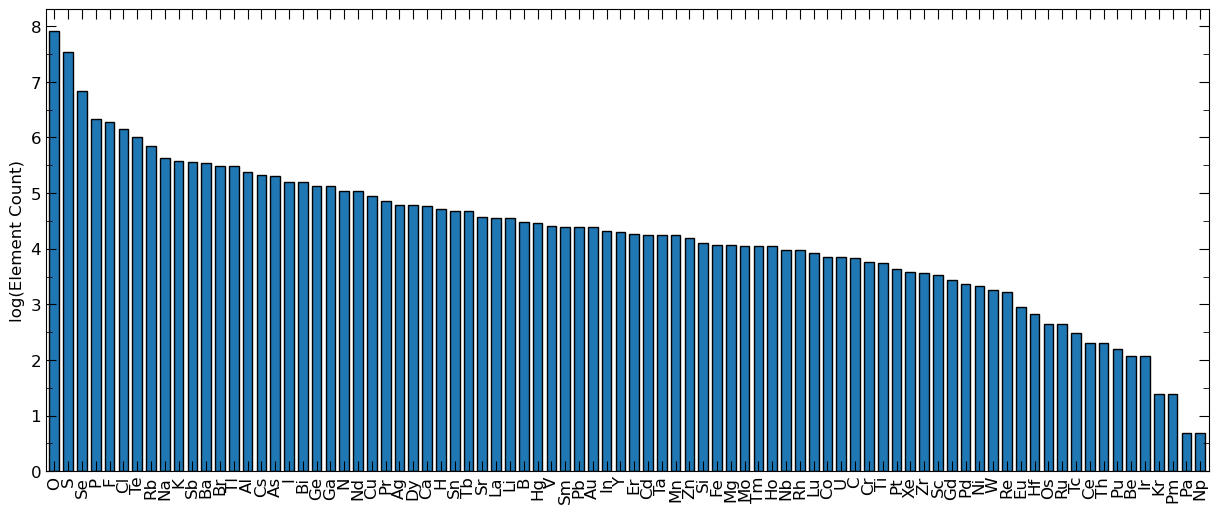

In [ ]:
# 误差小于0.1eV的元素分布
from Utools.ML_figures.figures import element_prevalence
import matplotlib.pyplot as plt

data_df = dft_test[dft_test['error'] < 0.1].copy()
current_dir = os.getcwd()
os.chdir('./Utools')  # Change to where ML_figures is a direct subdirectory

formula = data_df['composition']
save_dir = os.path.join(fig_path, 'error_less_than_0.1eV_elements_distribution')
os.makedirs(save_dir, exist_ok=True)
element_prevalence(formula,
                   name='element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=True)

plt.rcParams.update({'font.size': 12})
element_prevalence(formula,
                   name='element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=True)

os.chdir(current_dir)  # Return to previous directory